# <font color="blue">Project 2: DoppelGanger Find your Celebrity Look-Alike </font>
We have seen how face Recognition algorithms work. In short, they convert a face into a high dimensional vector and then learn a feature space in that high dimension. Once the algorithm learns a robust feature space, you can add more people to the same space and they will form a different cluster.

### <font color="green">Your Task</font>
In this project, we will build a Fun Application - We will use the Face Embeddings to **find a doppelganger or look-alike to a given person.** Specifically, we will give you images of two persons and a celebrity dataset. Your task will be to find their celebrity look-alike. The first person is **Sofia Solares** who looks like the American Singer **Selena Gomez** and the second one is **Shashikant Pedwal** who looks like Indian Film Actor **Amitabh Bachchan**.

Given below is the Expected Output. 

### <font color="green">Expected Output</font>

![](https://www.learnopencv.com/wp-content/uploads/2020/05/doppelganger-output-selena.jpg)

![](https://www.learnopencv.com/wp-content/uploads/2020/05/doppelganger-output-amitabh.jpg)


By now, you should be able to discern what the problem is, and how you are going to solve it. You simply need a dataset which has enough celebrity faces and use face embeddings to match the test image with the celebrity face embeddings. That's enough Hint!

## <font color="blue">The Dataset</font>
There are many datasets which contain images of celebrities. Some of them are:
* [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)
* [VGGFace](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/)
* [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/)
* [MS-Celeb-1M](https://www.microsoft.com/en-us/research/project/ms-celeb-1m-challenge-recognizing-one-million-celebrities-real-world/)
* [Celebrity-Together Dataset](https://www.robots.ox.ac.uk/~vgg/data/celebrity_together/)

### <font color="green">celeb_mini Dataset</font>
Since most of the datasets are huge in size, we have curated a small dataset for this experiment.

We will use a subset of the Query set of the Celebrity Together Dataset in this project. The query dataset has around 1100 celebs and is ~400MB in size. 

The subset we have created is using 5 images per celebrity and it has been saved in the **`../resource/asnlib/publicdata/celeb_mini`** folder. It is ~70MB in size. We have also provided a **`celeb_mapping.npy`** file which has the mapping of the code name to the actual name of the celebrity.

The **`celeb_mini`** folder has the following structure:

```
celeb_mini
└───n00000001
│   └──n00000001_00000263.JPEG
│   └──n00000001_00000405.JPEG
│      ...
└───n00000003
│   └──n00000003_00000386.JPEG
│   └──n00000003_00000488.JPEG
│       ...
│
```
    
**`celeb_mapping.npy`** contains a dictionary which contains the mapping between the folder names and the celebrity's actual name as show below:
```
{'n00000001': 'A.J. Buckley',
 'n00000002': 'A.R. Rahman',
 'n00000003': 'Aamir Khan',
 'n00000004': 'Aaron Staton',
 'n00000005': 'Aaron Tveit',
 'n00000006': 'Aaron Yoo',
 'n00000007': 'Abbie Cornish',
 .
 .
 .
}
```


## <font color="blue">Marks Distribution </font>
1. **Implementation - 70 Marks**
1. **Video Explanation - 30 marks**

#### <font color="red">Note that you are free to use any other dataset if you have the resources of space and compute to handle the large datasets.</font>


In [21]:
import os,random,glob
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import _pickle as cPickle
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

## <font color="blue">Load the model for face landmarks and face recognition</font>

Initialize Dlib’s Face Detector, Facial Landmark Detector and Face Recognition neural network objects

#### <font color="red">You are free to use other face recognition models as well. </font>

In [3]:
# Download dlib models
# Landmark model
!wget https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2 -O shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2
# Face recognition model
!wget https://github.com/davisking/dlib-models/raw/master/dlib_face_recognition_resnet_model_v1.dat.bz2 -O dlib_face_recognition_resnet_model_v1.dat.bz2
!bzip2 -d dlib_face_recognition_resnet_model_v1.dat.bz2
# Initialize face detector, facial landmarks detector 
# and face recognizer
faceDetector = dlib.get_frontal_face_detector()
shapePredictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
faceRecognizer = dlib.face_recognition_model_v1('dlib_face_recognition_resnet_model_v1.dat')

--2021-04-13 11:29:55--  https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/davisking/dlib-models/master/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2021-04-13 11:29:55--  https://raw.githubusercontent.com/davisking/dlib-models/master/shape_predictor_68_face_landmarks.dat.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M) [application/octet-stream]
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  14.5MB/s    in 4

## <font color="blue">Explore Data </font>
In this section, we provide sample code of how to load the images and use the label mapping for your reference. This should help you get started with handling images and finding the embeddings.

In [4]:
!wget https://www.dropbox.com/s/lulw2jwsblz687g/celeb_mini.zip?dl=1 -O celeb_mini.zip
!unzip celeb_mini.zip

!wget https://www.dropbox.com/s/m7kjjoa1z1hsxw6/celeb_mapping.npy?dl=1 -O celeb_mapping.npy

!wget https://www.dropbox.com/s/3yi89blp4lhiw6y/test-images.zip?dl=1 -O test-images.zip
!unzip test-images.zip

--2021-04-13 11:30:16--  https://www.dropbox.com/s/lulw2jwsblz687g/celeb_mini.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.11.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.11.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/lulw2jwsblz687g/celeb_mini.zip [following]
--2021-04-13 11:30:17--  https://www.dropbox.com/s/dl/lulw2jwsblz687g/celeb_mini.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc40b0d929b82afc006db0972842.dl.dropboxusercontent.com/cd/0/get/BMi7l1i9rjbpi3s9Oy9A_badGaTl5EtedT0bY7dN41QMEbTK5eGB0wjCFeI20sbHa5knMfQH0MB_YT4kFt_-SsyeKY0wkWL4Tc5oV5ETosaGvCzLJhfFJve0u-JE0k79XXjzFQrfD8IHpFSOakHjHgwc/file?dl=1# [following]
--2021-04-13 11:30:18--  https://uc40b0d929b82afc006db0972842.dl.dropboxusercontent.com/cd/0/get/BMi7l1i9rjbpi3s9Oy9A_badGaTl5EtedT0bY7dN41QMEbTK5eGB0wjCFeI20sbHa5knMfQH0MB_YT4k

  inflating: celeb_mini/n00001581/n00001581_00000765.JPEG  
  inflating: celeb_mini/n00001581/n00001581_00000525.JPEG  
  inflating: celeb_mini/n00001581/n00001581_00000533.JPEG  
   creating: celeb_mini/n00001945/
  inflating: celeb_mini/n00001945/n00001945_00000658.JPEG  
  inflating: celeb_mini/n00001945/n00001945_00000013.JPEG  
  inflating: celeb_mini/n00001945/n00001945_00000926.JPEG  
  inflating: celeb_mini/n00001945/n00001945_00000232.JPEG  
  inflating: celeb_mini/n00001945/n00001945_00000290.JPEG  
   creating: celeb_mini/n00001312/
  inflating: celeb_mini/n00001312/n00001312_00000295.JPEG  
  inflating: celeb_mini/n00001312/n00001312_00000324.JPEG  
  inflating: celeb_mini/n00001312/n00001312_00000112.JPEG  
  inflating: celeb_mini/n00001312/n00001312_00000807.JPEG  
  inflating: celeb_mini/n00001312/n00001312_00000692.JPEG  
   creating: celeb_mini/n00001737/
  inflating: celeb_mini/n00001737/n00001737_00000133.JPEG  
  inflating: celeb_mini/n00001737/n00001737_00000610.JP

  inflating: celeb_mini/n00002611/n00002611_00000145.JPEG  
  inflating: celeb_mini/n00002611/n00002611_00000831.JPEG  
  inflating: celeb_mini/n00002611/n00002611_00000796.JPEG  
  inflating: celeb_mini/n00002611/n00002611_00000523.JPEG  
  inflating: celeb_mini/n00002611/n00002611_00000519.JPEG  
   creating: celeb_mini/n00001649/
  inflating: celeb_mini/n00001649/n00001649_00000345.JPEG  
  inflating: celeb_mini/n00001649/n00001649_00000450.JPEG  
  inflating: celeb_mini/n00001649/n00001649_00000939.JPEG  
  inflating: celeb_mini/n00001649/n00001649_00000492.JPEG  
  inflating: celeb_mini/n00001649/n00001649_00000627.JPEG  
   creating: celeb_mini/n00001545/
  inflating: celeb_mini/n00001545/n00001545_00000132.JPEG  
  inflating: celeb_mini/n00001545/n00001545_00000738.JPEG  
  inflating: celeb_mini/n00001545/n00001545_00000934.JPEG  
  inflating: celeb_mini/n00001545/n00001545_00000630.JPEG  
  inflating: celeb_mini/n00001545/n00001545_00000515.JPEG  
   creating: celeb_mini/n00000

  inflating: celeb_mini/n00001826/n00001826_00000805.JPEG  
  inflating: celeb_mini/n00001826/n00001826_00000891.JPEG  
  inflating: celeb_mini/n00001826/n00001826_00000645.JPEG  
  inflating: celeb_mini/n00001826/n00001826_00000757.JPEG  
  inflating: celeb_mini/n00001826/n00001826_00000844.JPEG  
   creating: celeb_mini/n00000071/
  inflating: celeb_mini/n00000071/n00000071_00000721.JPEG  
  inflating: celeb_mini/n00000071/n00000071_00000347.JPEG  
  inflating: celeb_mini/n00000071/n00000071_00000081.JPEG  
  inflating: celeb_mini/n00000071/n00000071_00000608.JPEG  
  inflating: celeb_mini/n00000071/n00000071_00000405.JPEG  
   creating: celeb_mini/n00000487/
  inflating: celeb_mini/n00000487/n00000487_00000360.JPEG  
  inflating: celeb_mini/n00000487/n00000487_00000398.JPEG  
  inflating: celeb_mini/n00000487/n00000487_00000321.JPEG  
  inflating: celeb_mini/n00000487/n00000487_00000402.JPEG  
  inflating: celeb_mini/n00000487/n00000487_00000449.JPEG  
   creating: celeb_mini/n00001

  inflating: celeb_mini/n00001622/n00001622_00000202.JPEG  
  inflating: celeb_mini/n00001622/n00001622_00000463.JPEG  
  inflating: celeb_mini/n00001622/n00001622_00000652.JPEG  
  inflating: celeb_mini/n00001622/n00001622_00000224.JPEG  
   creating: celeb_mini/n00001937/
  inflating: celeb_mini/n00001937/n00001937_00000343.JPEG  
  inflating: celeb_mini/n00001937/n00001937_00000246.JPEG  
  inflating: celeb_mini/n00001937/n00001937_00000355.JPEG  
  inflating: celeb_mini/n00001937/n00001937_00000899.JPEG  
  inflating: celeb_mini/n00001937/n00001937_00000513.JPEG  
   creating: celeb_mini/n00002032/
  inflating: celeb_mini/n00002032/n00002032_00000109.JPEG  
  inflating: celeb_mini/n00002032/n00002032_00000236.JPEG  
  inflating: celeb_mini/n00002032/n00002032_00000173.JPEG  
  inflating: celeb_mini/n00002032/n00002032_00000108.JPEG  
  inflating: celeb_mini/n00002032/n00002032_00000515.JPEG  
   creating: celeb_mini/n00002228/
  inflating: celeb_mini/n00002228/n00002228_00000435.JP

  inflating: celeb_mini/n00002336/n00002336_00000662.JPEG  
  inflating: celeb_mini/n00002336/n00002336_00000382.JPEG  
   creating: celeb_mini/n00001734/
  inflating: celeb_mini/n00001734/n00001734_00000083.JPEG  
  inflating: celeb_mini/n00001734/n00001734_00000739.JPEG  
  inflating: celeb_mini/n00001734/n00001734_00000353.JPEG  
  inflating: celeb_mini/n00001734/n00001734_00000919.JPEG  
  inflating: celeb_mini/n00001734/n00001734_00000037.JPEG  
   creating: celeb_mini/n00000265/
  inflating: celeb_mini/n00000265/n00000265_00000094.JPEG  
  inflating: celeb_mini/n00000265/n00000265_00000164.JPEG  
  inflating: celeb_mini/n00000265/n00000265_00000466.JPEG  
  inflating: celeb_mini/n00000265/n00000265_00000344.JPEG  
  inflating: celeb_mini/n00000265/n00000265_00000348.JPEG  
   creating: celeb_mini/n00001906/
  inflating: celeb_mini/n00001906/n00001906_00000983.JPEG  
  inflating: celeb_mini/n00001906/n00001906_00000448.JPEG  
  inflating: celeb_mini/n00001906/n00001906_00000184.JP

  inflating: celeb_mini/n00000078/n00000078_00000415.JPEG  
   creating: celeb_mini/n00001235/
  inflating: celeb_mini/n00001235/n00001235_00000328.JPEG  
  inflating: celeb_mini/n00001235/n00001235_00000261.JPEG  
  inflating: celeb_mini/n00001235/n00001235_00000332.JPEG  
  inflating: celeb_mini/n00001235/n00001235_00000298.JPEG  
  inflating: celeb_mini/n00001235/n00001235_00000938.JPEG  
   creating: celeb_mini/n00000991/
  inflating: celeb_mini/n00000991/n00000991_00000730.JPEG  
  inflating: celeb_mini/n00000991/n00000991_00000615.JPEG  
  inflating: celeb_mini/n00000991/n00000991_00000028.JPEG  
  inflating: celeb_mini/n00000991/n00000991_00000008.JPEG  
  inflating: celeb_mini/n00000991/n00000991_00000032.JPEG  
   creating: celeb_mini/n00002214/
  inflating: celeb_mini/n00002214/n00002214_00000142.JPEG  
  inflating: celeb_mini/n00002214/n00002214_00000355.JPEG  
  inflating: celeb_mini/n00002214/n00002214_00000093.JPEG  
  inflating: celeb_mini/n00002214/n00002214_00000857.JP

  inflating: celeb_mini/n00002008/n00002008_00000739.JPEG  
   creating: celeb_mini/n00000553/
  inflating: celeb_mini/n00000553/n00000553_00000984.JPEG  
  inflating: celeb_mini/n00000553/n00000553_00000212.JPEG  
  inflating: celeb_mini/n00000553/n00000553_00000862.JPEG  
  inflating: celeb_mini/n00000553/n00000553_00000855.JPEG  
  inflating: celeb_mini/n00000553/n00000553_00000510.JPEG  
   creating: celeb_mini/n00000033/
  inflating: celeb_mini/n00000033/n00000033_00000713.JPEG  
  inflating: celeb_mini/n00000033/n00000033_00000569.JPEG  
  inflating: celeb_mini/n00000033/n00000033_00000705.JPEG  
  inflating: celeb_mini/n00000033/n00000033_00000637.JPEG  
  inflating: celeb_mini/n00000033/n00000033_00000512.JPEG  
   creating: celeb_mini/n00001430/
  inflating: celeb_mini/n00001430/n00001430_00000121.JPEG  
  inflating: celeb_mini/n00001430/n00001430_00000434.JPEG  
  inflating: celeb_mini/n00001430/n00001430_00000988.JPEG  
  inflating: celeb_mini/n00001430/n00001430_00000287.JP

  inflating: celeb_mini/n00000454/n00000454_00000444.JPEG  
  inflating: celeb_mini/n00000454/n00000454_00000917.JPEG  
  inflating: celeb_mini/n00000454/n00000454_00000326.JPEG  
  inflating: celeb_mini/n00000454/n00000454_00000425.JPEG  
  inflating: celeb_mini/n00000454/n00000454_00000202.JPEG  
   creating: celeb_mini/n00000959/
  inflating: celeb_mini/n00000959/n00000959_00000318.JPEG  
  inflating: celeb_mini/n00000959/n00000959_00000973.JPEG  
  inflating: celeb_mini/n00000959/n00000959_00000532.JPEG  
  inflating: celeb_mini/n00000959/n00000959_00000174.JPEG  
  inflating: celeb_mini/n00000959/n00000959_00000178.JPEG  
   creating: celeb_mini/n00001690/
  inflating: celeb_mini/n00001690/n00001690_00000646.JPEG  
  inflating: celeb_mini/n00001690/n00001690_00000261.JPEG  
  inflating: celeb_mini/n00001690/n00001690_00000095.JPEG  
  inflating: celeb_mini/n00001690/n00001690_00000168.JPEG  
  inflating: celeb_mini/n00001690/n00001690_00000200.JPEG  
   creating: celeb_mini/n00001

  inflating: celeb_mini/n00000112/n00000112_00000474.JPEG  
  inflating: celeb_mini/n00000112/n00000112_00000053.JPEG  
  inflating: celeb_mini/n00000112/n00000112_00000399.JPEG  
   creating: celeb_mini/n00001461/
  inflating: celeb_mini/n00001461/n00001461_00000313.JPEG  
  inflating: celeb_mini/n00001461/n00001461_00000260.JPEG  
  inflating: celeb_mini/n00001461/n00001461_00000128.JPEG  
  inflating: celeb_mini/n00001461/n00001461_00000734.JPEG  
  inflating: celeb_mini/n00001461/n00001461_00000344.JPEG  
   creating: celeb_mini/n00001656/
  inflating: celeb_mini/n00001656/n00001656_00000619.JPEG  
  inflating: celeb_mini/n00001656/n00001656_00000414.JPEG  
  inflating: celeb_mini/n00001656/n00001656_00000635.JPEG  
  inflating: celeb_mini/n00001656/n00001656_00000662.JPEG  
  inflating: celeb_mini/n00001656/n00001656_00000603.JPEG  
   creating: celeb_mini/n00000700/
  inflating: celeb_mini/n00000700/n00000700_00000236.JPEG  
  inflating: celeb_mini/n00000700/n00000700_00000283.JP

  inflating: celeb_mini/n00002451/n00002451_00000073.JPEG  
   creating: celeb_mini/n00002202/
  inflating: celeb_mini/n00002202/n00002202_00000064.JPEG  
  inflating: celeb_mini/n00002202/n00002202_00000204.JPEG  
  inflating: celeb_mini/n00002202/n00002202_00000316.JPEG  
  inflating: celeb_mini/n00002202/n00002202_00000177.JPEG  
  inflating: celeb_mini/n00002202/n00002202_00000438.JPEG  
   creating: celeb_mini/n00000898/
  inflating: celeb_mini/n00000898/n00000898_00000377.JPEG  
  inflating: celeb_mini/n00000898/n00000898_00000025.JPEG  
  inflating: celeb_mini/n00000898/n00000898_00000481.JPEG  
  inflating: celeb_mini/n00000898/n00000898_00000194.JPEG  
  inflating: celeb_mini/n00000898/n00000898_00000204.JPEG  
   creating: celeb_mini/n00000903/
  inflating: celeb_mini/n00000903/n00000903_00000504.JPEG  
  inflating: celeb_mini/n00000903/n00000903_00000617.JPEG  
  inflating: celeb_mini/n00000903/n00000903_00000285.JPEG  
  inflating: celeb_mini/n00000903/n00000903_00000924.JP

  inflating: celeb_mini/n00001127/n00001127_00000159.JPEG  
   creating: celeb_mini/n00000521/
  inflating: celeb_mini/n00000521/n00000521_00000553.JPEG  
  inflating: celeb_mini/n00000521/n00000521_00000457.JPEG  
  inflating: celeb_mini/n00000521/n00000521_00000964.JPEG  
  inflating: celeb_mini/n00000521/n00000521_00000206.JPEG  
  inflating: celeb_mini/n00000521/n00000521_00000363.JPEG  
   creating: celeb_mini/n00001155/
  inflating: celeb_mini/n00001155/n00001155_00000879.JPEG  
  inflating: celeb_mini/n00001155/n00001155_00000101.JPEG  
  inflating: celeb_mini/n00001155/n00001155_00000137.JPEG  
  inflating: celeb_mini/n00001155/n00001155_00000863.JPEG  
  inflating: celeb_mini/n00001155/n00001155_00000361.JPEG  
   creating: celeb_mini/n00001930/
  inflating: celeb_mini/n00001930/n00001930_00000163.JPEG  
  inflating: celeb_mini/n00001930/n00001930_00000227.JPEG  
  inflating: celeb_mini/n00001930/n00001930_00000572.JPEG  
  inflating: celeb_mini/n00001930/n00001930_00000437.JP

  inflating: celeb_mini/n00000201/n00000201_00000670.JPEG  
  inflating: celeb_mini/n00000201/n00000201_00000021.JPEG  
   creating: celeb_mini/n00001196/
  inflating: celeb_mini/n00001196/n00001196_00000805.JPEG  
  inflating: celeb_mini/n00001196/n00001196_00000043.JPEG  
  inflating: celeb_mini/n00001196/n00001196_00000111.JPEG  
  inflating: celeb_mini/n00001196/n00001196_00000687.JPEG  
  inflating: celeb_mini/n00001196/n00001196_00000107.JPEG  
   creating: celeb_mini/n00000779/
  inflating: celeb_mini/n00000779/n00000779_00000820.JPEG  
  inflating: celeb_mini/n00000779/n00000779_00000400.JPEG  
  inflating: celeb_mini/n00000779/n00000779_00000267.JPEG  
  inflating: celeb_mini/n00000779/n00000779_00000912.JPEG  
  inflating: celeb_mini/n00000779/n00000779_00000011.JPEG  
   creating: celeb_mini/n00001684/
  inflating: celeb_mini/n00001684/n00001684_00000169.JPEG  
  inflating: celeb_mini/n00001684/n00001684_00000796.JPEG  
  inflating: celeb_mini/n00001684/n00001684_00000128.JP

  inflating: celeb_mini/n00001738/n00001738_00000073.JPEG  
  inflating: celeb_mini/n00001738/n00001738_00000395.JPEG  
  inflating: celeb_mini/n00001738/n00001738_00000815.JPEG  
  inflating: celeb_mini/n00001738/n00001738_00000602.JPEG  
   creating: celeb_mini/n00000106/
  inflating: celeb_mini/n00000106/n00000106_00000402.JPEG  
  inflating: celeb_mini/n00000106/n00000106_00000033.JPEG  
  inflating: celeb_mini/n00000106/n00000106_00000588.JPEG  
  inflating: celeb_mini/n00000106/n00000106_00000422.JPEG  
  inflating: celeb_mini/n00000106/n00000106_00000727.JPEG  
   creating: celeb_mini/n00002149/
  inflating: celeb_mini/n00002149/n00002149_00000777.JPEG  
  inflating: celeb_mini/n00002149/n00002149_00000278.JPEG  
  inflating: celeb_mini/n00002149/n00002149_00000873.JPEG  
  inflating: celeb_mini/n00002149/n00002149_00000404.JPEG  
  inflating: celeb_mini/n00002149/n00002149_00000665.JPEG  
   creating: celeb_mini/n00000083/
  inflating: celeb_mini/n00000083/n00000083_00000518.JP

  inflating: celeb_mini/n00000255/n00000255_00000553.JPEG  
  inflating: celeb_mini/n00000255/n00000255_00000047.JPEG  
   creating: celeb_mini/n00000399/
  inflating: celeb_mini/n00000399/n00000399_00000469.JPEG  
  inflating: celeb_mini/n00000399/n00000399_00000595.JPEG  
  inflating: celeb_mini/n00000399/n00000399_00000612.JPEG  
  inflating: celeb_mini/n00000399/n00000399_00000235.JPEG  
  inflating: celeb_mini/n00000399/n00000399_00000691.JPEG  
   creating: celeb_mini/n00001174/
  inflating: celeb_mini/n00001174/n00001174_00000754.JPEG  
  inflating: celeb_mini/n00001174/n00001174_00000017.JPEG  
  inflating: celeb_mini/n00001174/n00001174_00000369.JPEG  
  inflating: celeb_mini/n00001174/n00001174_00000955.JPEG  
  inflating: celeb_mini/n00001174/n00001174_00000543.JPEG  
   creating: celeb_mini/n00000239/
  inflating: celeb_mini/n00000239/n00000239_00000604.JPEG  
  inflating: celeb_mini/n00000239/n00000239_00000080.JPEG  
  inflating: celeb_mini/n00000239/n00000239_00000794.JP

  inflating: celeb_mini/n00001020/n00001020_00000040.JPEG  
  inflating: celeb_mini/n00001020/n00001020_00000369.JPEG  
  inflating: celeb_mini/n00001020/n00001020_00000076.JPEG  
  inflating: celeb_mini/n00001020/n00001020_00000083.JPEG  
  inflating: celeb_mini/n00001020/n00001020_00000373.JPEG  
   creating: celeb_mini/n00001112/
  inflating: celeb_mini/n00001112/n00001112_00000035.JPEG  
  inflating: celeb_mini/n00001112/n00001112_00000219.JPEG  
  inflating: celeb_mini/n00001112/n00001112_00000346.JPEG  
  inflating: celeb_mini/n00001112/n00001112_00000350.JPEG  
  inflating: celeb_mini/n00001112/n00001112_00000424.JPEG  
   creating: celeb_mini/n00000335/
  inflating: celeb_mini/n00000335/n00000335_00000076.JPEG  
  inflating: celeb_mini/n00000335/n00000335_00000169.JPEG  
  inflating: celeb_mini/n00000335/n00000335_00000489.JPEG  
  inflating: celeb_mini/n00000335/n00000335_00000108.JPEG  
  inflating: celeb_mini/n00000335/n00000335_00000466.JPEG  
   creating: celeb_mini/n00002

--2021-04-13 11:30:26--  https://www.dropbox.com/s/m7kjjoa1z1hsxw6/celeb_mapping.npy?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.11.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.11.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/m7kjjoa1z1hsxw6/celeb_mapping.npy [following]
--2021-04-13 11:30:27--  https://www.dropbox.com/s/dl/m7kjjoa1z1hsxw6/celeb_mapping.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfba70fe430773aabe9967b4c81.dl.dropboxusercontent.com/cd/0/get/BMgYTskq6L1kV79tJcPqTdu_xL0FyAuRgFwO7RPAupoRSho7EYlJ9-kvRJO5LKftxi_n2XkkrAwkjQrGf87514FaUz0dJBSEqxdRHPRfVXNw33jm3vQK_MKmHVU8B1PU_oKm5PWmPWI-OCEoFbC7YLR5/file?dl=1# [following]
--2021-04-13 11:30:28--  https://ucfba70fe430773aabe9967b4c81.dl.dropboxusercontent.com/cd/0/get/BMgYTskq6L1kV79tJcPqTdu_xL0FyAuRgFwO7RPAupoRSho7EYlJ9-kvRJO5LKftxi_n2Xk

In [11]:
# Root folder of the dataset
faceDatasetFolder = 'celeb_mini'
# Label -> Name Mapping file
labelMap = np.load("celeb_mapping.npy", allow_pickle=True).item()

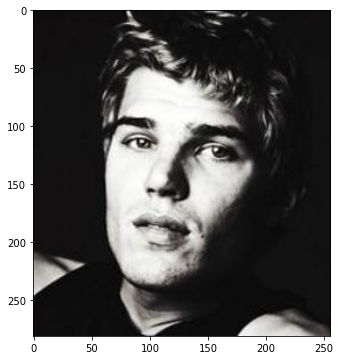

File path = celeb_mini/n00000369/n00000369_00000074.JPEG
Celeb Name: Chris Zylka


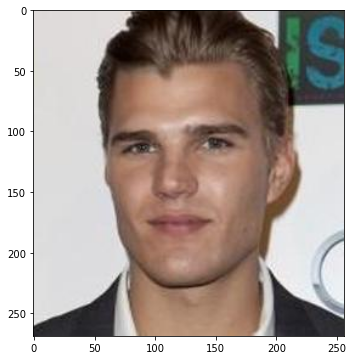

File path = celeb_mini/n00000369/n00000369_00000166.JPEG
Celeb Name: Chris Zylka


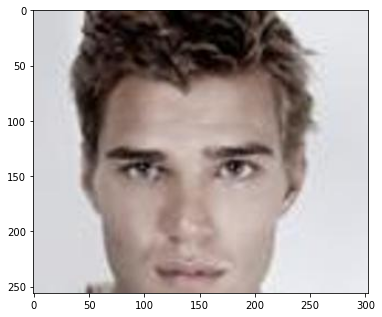

File path = celeb_mini/n00000369/n00000369_00000520.JPEG
Celeb Name: Chris Zylka


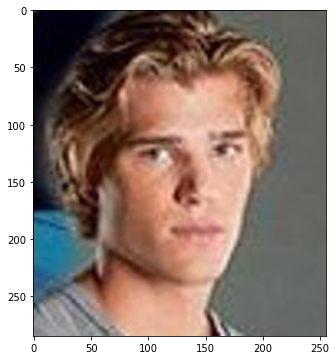

File path = celeb_mini/n00000369/n00000369_00000491.JPEG
Celeb Name: Chris Zylka


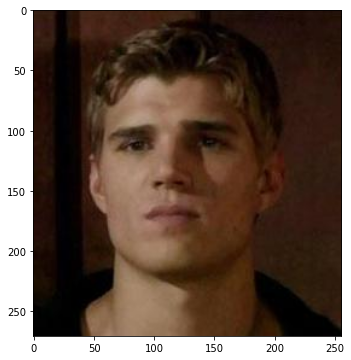

File path = celeb_mini/n00000369/n00000369_00000429.JPEG
Celeb Name: Chris Zylka


In [7]:
# Each subfolder has images of a particular celeb
subfolders = os.listdir(faceDatasetFolder)

# Let us choose a random folder and display all images
random_folder = random.choice(subfolders)

# Also find out the name of the celeb from the folder name and folder-> name mapping dictionary loaded earlier
celebname = labelMap[random_folder]

# Load all images in the subfolder
imagefiles = os.listdir(os.path.join(faceDatasetFolder, random_folder))

# Read each image and display along with the filename and celeb name
for file in imagefiles:
#     Get full path of each image file
    fullPath = os.path.join(faceDatasetFolder,random_folder,file)
    im = cv2.imread(fullPath)
    plt.imshow(im[:,:,::-1])
    plt.show()
#     Also print the filename and celeb name
    print("File path = {}".format(fullPath))
    print("Celeb Name: {}".format(celebname))

## <font color="blue">TODO</font>
You have to write the code for enrollment and testing to get the desired output as shown in the intro section.

**You can take help from the code we had provided in week 4 material.**

## <font color="red">1. Enrollment of Celeb Images </font>
Process images one by and one. 

Convert image from RGB to BGR, because Dlib uses RGB as default format.

Detect faces in the image and compute a face descriptor for each image and save them in an array so that it can be used during testing.

In [16]:
# read subfolders in dataset
subfolders = []
for x in os.listdir(faceDatasetFolder):
  xpath = os.path.join(faceDatasetFolder, x)
  if os.path.isdir(xpath):
    subfolders.append(xpath)

nameLabelMap = {}
labels = []
imagePaths = []
for i, subfolder in enumerate(subfolders):
  for x in os.listdir(subfolder):
    xpath = os.path.join(subfolder, x)
    if x.endswith('JPEG'):
      imagePaths.append(xpath)
      labels.append(i)
      nameLabelMap[xpath] = subfolder.split('/')[-1]

In [19]:
index = {}
i = 0
faceDescriptors = None
for imagePath in imagePaths:
  print("processing: {}".format(imagePath))
  # read image and convert it to RGB
  img = cv2.imread(imagePath)
  # detect faces in image
  faces = faceDetector(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  print("{} Face(s) found".format(len(faces)))
  # Now process each face we found
  for k, face in enumerate(faces):

    # Find facial landmarks for each detected face
    shape = shapePredictor(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), face)

    # convert landmarks from Dlib's format to list of (x, y) points
    landmarks = [(p.x, p.y) for p in shape.parts()]

    # Compute face descriptor using neural network defined in Dlib.
    # It is a 128D vector that describes the face in img identified by shape.
    faceDescriptor = faceRecognizer.compute_face_descriptor(img, shape)

    # Convert face descriptor from Dlib's format to list, then a NumPy array
    faceDescriptorList = [x for x in faceDescriptor]
    faceDescriptorNdarray = np.asarray(faceDescriptorList, dtype=np.float64)
    faceDescriptorNdarray = faceDescriptorNdarray[np.newaxis, :]

    # Stack face descriptors (1x128) for each face in images, as rows
    if faceDescriptors is None:
      faceDescriptors = faceDescriptorNdarray
    else:
      faceDescriptors = np.concatenate((faceDescriptors, faceDescriptorNdarray), axis=0)

    # save the label for this face in index. We will use it later to identify
    # person name corresponding to face descriptors stored in NumPy Array
    index[i] = nameLabelMap[imagePath]
    i += 1

processing: celeb_mini/n00000257/n00000257_00000434.JPEG
1 Face(s) found
processing: celeb_mini/n00000257/n00000257_00000116.JPEG
1 Face(s) found
processing: celeb_mini/n00000257/n00000257_00000052.JPEG
1 Face(s) found
processing: celeb_mini/n00000257/n00000257_00000403.JPEG
1 Face(s) found
processing: celeb_mini/n00000257/n00000257_00000160.JPEG
1 Face(s) found
processing: celeb_mini/n00000102/n00000102_00000510.JPEG
1 Face(s) found
processing: celeb_mini/n00000102/n00000102_00000547.JPEG
1 Face(s) found
processing: celeb_mini/n00000102/n00000102_00000434.JPEG
1 Face(s) found
processing: celeb_mini/n00000102/n00000102_00000588.JPEG
1 Face(s) found
processing: celeb_mini/n00000102/n00000102_00000068.JPEG
1 Face(s) found
processing: celeb_mini/n00001463/n00001463_00000576.JPEG
1 Face(s) found
processing: celeb_mini/n00001463/n00001463_00000043.JPEG
1 Face(s) found
processing: celeb_mini/n00001463/n00001463_00000311.JPEG
1 Face(s) found
processing: celeb_mini/n00001463/n00001463_00000307

1 Face(s) found
processing: celeb_mini/n00002228/n00002228_00000182.JPEG
1 Face(s) found
processing: celeb_mini/n00002228/n00002228_00000013.JPEG
1 Face(s) found
processing: celeb_mini/n00002228/n00002228_00000435.JPEG
1 Face(s) found
processing: celeb_mini/n00002228/n00002228_00000474.JPEG
1 Face(s) found
processing: celeb_mini/n00002228/n00002228_00000439.JPEG
1 Face(s) found
processing: celeb_mini/n00001755/n00001755_00000500.JPEG
1 Face(s) found
processing: celeb_mini/n00001755/n00001755_00000537.JPEG
1 Face(s) found
processing: celeb_mini/n00001755/n00001755_00000701.JPEG
1 Face(s) found
processing: celeb_mini/n00001755/n00001755_00000445.JPEG
1 Face(s) found
processing: celeb_mini/n00001755/n00001755_00000097.JPEG
1 Face(s) found
processing: celeb_mini/n00000032/n00000032_00000136.JPEG
1 Face(s) found
processing: celeb_mini/n00000032/n00000032_00000117.JPEG
1 Face(s) found
processing: celeb_mini/n00000032/n00000032_00000643.JPEG
1 Face(s) found
processing: celeb_mini/n00000032/n0

1 Face(s) found
processing: celeb_mini/n00000465/n00000465_00000118.JPEG
1 Face(s) found
processing: celeb_mini/n00000465/n00000465_00000549.JPEG
1 Face(s) found
processing: celeb_mini/n00000852/n00000852_00000788.JPEG
1 Face(s) found
processing: celeb_mini/n00000852/n00000852_00000458.JPEG
1 Face(s) found
processing: celeb_mini/n00000852/n00000852_00000507.JPEG
1 Face(s) found
processing: celeb_mini/n00000852/n00000852_00000570.JPEG
1 Face(s) found
processing: celeb_mini/n00000852/n00000852_00000531.JPEG
1 Face(s) found
processing: celeb_mini/n00000279/n00000279_00000971.JPEG
1 Face(s) found
processing: celeb_mini/n00000279/n00000279_00000068.JPEG
1 Face(s) found
processing: celeb_mini/n00000279/n00000279_00000766.JPEG
1 Face(s) found
processing: celeb_mini/n00000279/n00000279_00000815.JPEG
1 Face(s) found
processing: celeb_mini/n00000279/n00000279_00000454.JPEG
1 Face(s) found
processing: celeb_mini/n00002451/n00002451_00000252.JPEG
1 Face(s) found
processing: celeb_mini/n00002451/n0

1 Face(s) found
processing: celeb_mini/n00002089/n00002089_00000079.JPEG
1 Face(s) found
processing: celeb_mini/n00002089/n00002089_00000296.JPEG
1 Face(s) found
processing: celeb_mini/n00000767/n00000767_00000298.JPEG
1 Face(s) found
processing: celeb_mini/n00000767/n00000767_00000133.JPEG
0 Face(s) found
processing: celeb_mini/n00000767/n00000767_00000467.JPEG
0 Face(s) found
processing: celeb_mini/n00000767/n00000767_00000627.JPEG
1 Face(s) found
processing: celeb_mini/n00000767/n00000767_00000426.JPEG
1 Face(s) found
processing: celeb_mini/n00002261/n00002261_00000771.JPEG
1 Face(s) found
processing: celeb_mini/n00002261/n00002261_00000622.JPEG
1 Face(s) found
processing: celeb_mini/n00002261/n00002261_00000638.JPEG
0 Face(s) found
processing: celeb_mini/n00002261/n00002261_00000531.JPEG
1 Face(s) found
processing: celeb_mini/n00002261/n00002261_00000966.JPEG
1 Face(s) found
processing: celeb_mini/n00000034/n00000034_00000591.JPEG
1 Face(s) found
processing: celeb_mini/n00000034/n0

1 Face(s) found
processing: celeb_mini/n00002569/n00002569_00000470.JPEG
1 Face(s) found
processing: celeb_mini/n00002569/n00002569_00000391.JPEG
1 Face(s) found
processing: celeb_mini/n00002569/n00002569_00000082.JPEG
1 Face(s) found
processing: celeb_mini/n00001921/n00001921_00000679.JPEG
1 Face(s) found
processing: celeb_mini/n00001921/n00001921_00000377.JPEG
1 Face(s) found
processing: celeb_mini/n00001921/n00001921_00000655.JPEG
1 Face(s) found
processing: celeb_mini/n00001921/n00001921_00000264.JPEG
1 Face(s) found
processing: celeb_mini/n00001921/n00001921_00000680.JPEG
1 Face(s) found
processing: celeb_mini/n00000672/n00000672_00000252.JPEG
1 Face(s) found
processing: celeb_mini/n00000672/n00000672_00000403.JPEG
1 Face(s) found
processing: celeb_mini/n00000672/n00000672_00000570.JPEG
1 Face(s) found
processing: celeb_mini/n00000672/n00000672_00000090.JPEG
1 Face(s) found
processing: celeb_mini/n00000672/n00000672_00000593.JPEG
1 Face(s) found
processing: celeb_mini/n00002416/n0

1 Face(s) found
processing: celeb_mini/n00000384/n00000384_00000228.JPEG
1 Face(s) found
processing: celeb_mini/n00000384/n00000384_00000455.JPEG
1 Face(s) found
processing: celeb_mini/n00000384/n00000384_00000101.JPEG
1 Face(s) found
processing: celeb_mini/n00000384/n00000384_00000137.JPEG
1 Face(s) found
processing: celeb_mini/n00001709/n00001709_00000372.JPEG
1 Face(s) found
processing: celeb_mini/n00001709/n00001709_00000631.JPEG
1 Face(s) found
processing: celeb_mini/n00001709/n00001709_00000165.JPEG
1 Face(s) found
processing: celeb_mini/n00001709/n00001709_00000241.JPEG
1 Face(s) found
processing: celeb_mini/n00001709/n00001709_00000020.JPEG
1 Face(s) found
processing: celeb_mini/n00001283/n00001283_00000045.JPEG
1 Face(s) found
processing: celeb_mini/n00001283/n00001283_00000455.JPEG
1 Face(s) found
processing: celeb_mini/n00001283/n00001283_00000013.JPEG
1 Face(s) found
processing: celeb_mini/n00001283/n00001283_00000194.JPEG
1 Face(s) found
processing: celeb_mini/n00001283/n0

1 Face(s) found
processing: celeb_mini/n00002033/n00002033_00000998.JPEG
1 Face(s) found
processing: celeb_mini/n00000170/n00000170_00000932.JPEG
1 Face(s) found
processing: celeb_mini/n00000170/n00000170_00000285.JPEG
1 Face(s) found
processing: celeb_mini/n00000170/n00000170_00000894.JPEG
1 Face(s) found
processing: celeb_mini/n00000170/n00000170_00000070.JPEG
1 Face(s) found
processing: celeb_mini/n00000170/n00000170_00000928.JPEG
1 Face(s) found
processing: celeb_mini/n00000038/n00000038_00000438.JPEG
1 Face(s) found
processing: celeb_mini/n00000038/n00000038_00000594.JPEG
1 Face(s) found
processing: celeb_mini/n00000038/n00000038_00000003.JPEG
1 Face(s) found
processing: celeb_mini/n00000038/n00000038_00000757.JPEG
1 Face(s) found
processing: celeb_mini/n00000038/n00000038_00000347.JPEG
0 Face(s) found
processing: celeb_mini/n00000107/n00000107_00000591.JPEG
1 Face(s) found
processing: celeb_mini/n00000107/n00000107_00000363.JPEG
1 Face(s) found
processing: celeb_mini/n00000107/n0

processing: celeb_mini/n00000018/n00000018_00000317.JPEG
1 Face(s) found
processing: celeb_mini/n00000018/n00000018_00000458.JPEG
0 Face(s) found
processing: celeb_mini/n00000378/n00000378_00000466.JPEG
1 Face(s) found
processing: celeb_mini/n00000378/n00000378_00000329.JPEG
1 Face(s) found
processing: celeb_mini/n00000378/n00000378_00000145.JPEG
1 Face(s) found
processing: celeb_mini/n00000378/n00000378_00000149.JPEG
1 Face(s) found
processing: celeb_mini/n00000378/n00000378_00000036.JPEG
1 Face(s) found
processing: celeb_mini/n00001212/n00001212_00000461.JPEG
1 Face(s) found
processing: celeb_mini/n00001212/n00001212_00000705.JPEG
1 Face(s) found
processing: celeb_mini/n00001212/n00001212_00000553.JPEG
1 Face(s) found
processing: celeb_mini/n00001212/n00001212_00000181.JPEG
1 Face(s) found
processing: celeb_mini/n00001212/n00001212_00000359.JPEG
1 Face(s) found
processing: celeb_mini/n00001382/n00001382_00000554.JPEG
1 Face(s) found
processing: celeb_mini/n00001382/n00001382_00000332

1 Face(s) found
processing: celeb_mini/n00000624/n00000624_00000902.JPEG
1 Face(s) found
processing: celeb_mini/n00000624/n00000624_00000332.JPEG
1 Face(s) found
processing: celeb_mini/n00000624/n00000624_00000426.JPEG
1 Face(s) found
processing: celeb_mini/n00000624/n00000624_00000538.JPEG
1 Face(s) found
processing: celeb_mini/n00000624/n00000624_00000304.JPEG
1 Face(s) found
processing: celeb_mini/n00000449/n00000449_00000454.JPEG
1 Face(s) found
processing: celeb_mini/n00000449/n00000449_00000730.JPEG
1 Face(s) found
processing: celeb_mini/n00000449/n00000449_00000751.JPEG
1 Face(s) found
processing: celeb_mini/n00000449/n00000449_00000593.JPEG
1 Face(s) found
processing: celeb_mini/n00000449/n00000449_00000161.JPEG
1 Face(s) found
processing: celeb_mini/n00000342/n00000342_00000216.JPEG
1 Face(s) found
processing: celeb_mini/n00000342/n00000342_00000518.JPEG
1 Face(s) found
processing: celeb_mini/n00000342/n00000342_00000755.JPEG
1 Face(s) found
processing: celeb_mini/n00000342/n0

1 Face(s) found
processing: celeb_mini/n00001297/n00001297_00000213.JPEG
1 Face(s) found
processing: celeb_mini/n00001297/n00001297_00000479.JPEG
1 Face(s) found
processing: celeb_mini/n00001297/n00001297_00000480.JPEG
1 Face(s) found
processing: celeb_mini/n00001297/n00001297_00000395.JPEG
1 Face(s) found
processing: celeb_mini/n00001966/n00001966_00000035.JPEG
1 Face(s) found
processing: celeb_mini/n00001966/n00001966_00000412.JPEG
1 Face(s) found
processing: celeb_mini/n00001966/n00001966_00000756.JPEG
1 Face(s) found
processing: celeb_mini/n00001966/n00001966_00000500.JPEG
1 Face(s) found
processing: celeb_mini/n00001966/n00001966_00000776.JPEG
1 Face(s) found
processing: celeb_mini/n00001954/n00001954_00000270.JPEG
1 Face(s) found
processing: celeb_mini/n00001954/n00001954_00000302.JPEG
1 Face(s) found
processing: celeb_mini/n00001954/n00001954_00000676.JPEG
1 Face(s) found
processing: celeb_mini/n00001954/n00001954_00000251.JPEG
1 Face(s) found
processing: celeb_mini/n00001954/n0

1 Face(s) found
processing: celeb_mini/n00001982/n00001982_00000649.JPEG
1 Face(s) found
processing: celeb_mini/n00000556/n00000556_00000250.JPEG
1 Face(s) found
processing: celeb_mini/n00000556/n00000556_00000591.JPEG
1 Face(s) found
processing: celeb_mini/n00000556/n00000556_00000270.JPEG
1 Face(s) found
processing: celeb_mini/n00000556/n00000556_00000155.JPEG
1 Face(s) found
processing: celeb_mini/n00000556/n00000556_00000564.JPEG
1 Face(s) found
processing: celeb_mini/n00001736/n00001736_00000222.JPEG
1 Face(s) found
processing: celeb_mini/n00001736/n00001736_00000598.JPEG
1 Face(s) found
processing: celeb_mini/n00001736/n00001736_00000760.JPEG
1 Face(s) found
processing: celeb_mini/n00001736/n00001736_00000078.JPEG
1 Face(s) found
processing: celeb_mini/n00001736/n00001736_00000737.JPEG
1 Face(s) found
processing: celeb_mini/n00001778/n00001778_00000429.JPEG
1 Face(s) found
processing: celeb_mini/n00001778/n00001778_00000059.JPEG
1 Face(s) found
processing: celeb_mini/n00001778/n0

1 Face(s) found
processing: celeb_mini/n00001224/n00001224_00000185.JPEG
1 Face(s) found
processing: celeb_mini/n00001224/n00001224_00000977.JPEG
1 Face(s) found
processing: celeb_mini/n00001224/n00001224_00000605.JPEG
1 Face(s) found
processing: celeb_mini/n00001224/n00001224_00000306.JPEG
1 Face(s) found
processing: celeb_mini/n00001338/n00001338_00000671.JPEG
1 Face(s) found
processing: celeb_mini/n00001338/n00001338_00000503.JPEG
1 Face(s) found
processing: celeb_mini/n00001338/n00001338_00000283.JPEG
1 Face(s) found
processing: celeb_mini/n00001338/n00001338_00000780.JPEG
1 Face(s) found
processing: celeb_mini/n00001338/n00001338_00000735.JPEG
1 Face(s) found
processing: celeb_mini/n00002062/n00002062_00000532.JPEG
0 Face(s) found
processing: celeb_mini/n00002062/n00002062_00000251.JPEG
1 Face(s) found
processing: celeb_mini/n00002062/n00002062_00000904.JPEG
1 Face(s) found
processing: celeb_mini/n00002062/n00002062_00000139.JPEG
1 Face(s) found
processing: celeb_mini/n00002062/n0

1 Face(s) found
processing: celeb_mini/n00000315/n00000315_00000676.JPEG
0 Face(s) found
processing: celeb_mini/n00000315/n00000315_00000089.JPEG
1 Face(s) found
processing: celeb_mini/n00000315/n00000315_00000601.JPEG
1 Face(s) found
processing: celeb_mini/n00000315/n00000315_00000210.JPEG
1 Face(s) found
processing: celeb_mini/n00002364/n00002364_00000112.JPEG
1 Face(s) found
processing: celeb_mini/n00002364/n00002364_00000515.JPEG
1 Face(s) found
processing: celeb_mini/n00002364/n00002364_00000775.JPEG
1 Face(s) found
processing: celeb_mini/n00002364/n00002364_00000082.JPEG
1 Face(s) found
processing: celeb_mini/n00002364/n00002364_00000651.JPEG
1 Face(s) found
processing: celeb_mini/n00000167/n00000167_00000230.JPEG
1 Face(s) found
processing: celeb_mini/n00000167/n00000167_00000769.JPEG
1 Face(s) found
processing: celeb_mini/n00000167/n00000167_00000284.JPEG
1 Face(s) found
processing: celeb_mini/n00000167/n00000167_00000528.JPEG
1 Face(s) found
processing: celeb_mini/n00000167/n0

1 Face(s) found
processing: celeb_mini/n00000747/n00000747_00000250.JPEG
1 Face(s) found
processing: celeb_mini/n00000747/n00000747_00000397.JPEG
1 Face(s) found
processing: celeb_mini/n00000747/n00000747_00000319.JPEG
1 Face(s) found
processing: celeb_mini/n00000747/n00000747_00000929.JPEG
1 Face(s) found
processing: celeb_mini/n00000747/n00000747_00000051.JPEG
1 Face(s) found
processing: celeb_mini/n00000453/n00000453_00000472.JPEG
1 Face(s) found
processing: celeb_mini/n00000453/n00000453_00000540.JPEG
1 Face(s) found
processing: celeb_mini/n00000453/n00000453_00000219.JPEG
1 Face(s) found
processing: celeb_mini/n00000453/n00000453_00000813.JPEG
1 Face(s) found
processing: celeb_mini/n00000453/n00000453_00000366.JPEG
1 Face(s) found
processing: celeb_mini/n00000278/n00000278_00000641.JPEG
1 Face(s) found
processing: celeb_mini/n00000278/n00000278_00000729.JPEG
1 Face(s) found
processing: celeb_mini/n00000278/n00000278_00000744.JPEG
1 Face(s) found
processing: celeb_mini/n00000278/n0

1 Face(s) found
processing: celeb_mini/n00001064/n00001064_00000748.JPEG
0 Face(s) found
processing: celeb_mini/n00001064/n00001064_00000494.JPEG
1 Face(s) found
processing: celeb_mini/n00001064/n00001064_00000011.JPEG
1 Face(s) found
processing: celeb_mini/n00001983/n00001983_00000298.JPEG
1 Face(s) found
processing: celeb_mini/n00001983/n00001983_00000488.JPEG
1 Face(s) found
processing: celeb_mini/n00001983/n00001983_00000277.JPEG
1 Face(s) found
processing: celeb_mini/n00001983/n00001983_00000390.JPEG
1 Face(s) found
processing: celeb_mini/n00001983/n00001983_00000830.JPEG
1 Face(s) found
processing: celeb_mini/n00001405/n00001405_00000410.JPEG
1 Face(s) found
processing: celeb_mini/n00001405/n00001405_00000261.JPEG
1 Face(s) found
processing: celeb_mini/n00001405/n00001405_00000535.JPEG
1 Face(s) found
processing: celeb_mini/n00001405/n00001405_00000810.JPEG
1 Face(s) found
processing: celeb_mini/n00001405/n00001405_00000563.JPEG
1 Face(s) found
processing: celeb_mini/n00002354/n0

processing: celeb_mini/n00000366/n00000366_00000030.JPEG
1 Face(s) found
processing: celeb_mini/n00000366/n00000366_00000084.JPEG
1 Face(s) found
processing: celeb_mini/n00000936/n00000936_00000258.JPEG
1 Face(s) found
processing: celeb_mini/n00000936/n00000936_00000560.JPEG
1 Face(s) found
processing: celeb_mini/n00000936/n00000936_00000192.JPEG
1 Face(s) found
processing: celeb_mini/n00000936/n00000936_00000649.JPEG
1 Face(s) found
processing: celeb_mini/n00000936/n00000936_00000254.JPEG
1 Face(s) found
processing: celeb_mini/n00002580/n00002580_00000933.JPEG
1 Face(s) found
processing: celeb_mini/n00002580/n00002580_00000928.JPEG
1 Face(s) found
processing: celeb_mini/n00002580/n00002580_00000271.JPEG
1 Face(s) found
processing: celeb_mini/n00002580/n00002580_00000139.JPEG
1 Face(s) found
processing: celeb_mini/n00002580/n00002580_00000085.JPEG
1 Face(s) found
processing: celeb_mini/n00002057/n00002057_00000808.JPEG
0 Face(s) found
processing: celeb_mini/n00002057/n00002057_00000170

processing: celeb_mini/n00000207/n00000207_00000078.JPEG
1 Face(s) found
processing: celeb_mini/n00002501/n00002501_00000435.JPEG
1 Face(s) found
processing: celeb_mini/n00002501/n00002501_00000161.JPEG
1 Face(s) found
processing: celeb_mini/n00002501/n00002501_00000675.JPEG
1 Face(s) found
processing: celeb_mini/n00002501/n00002501_00000946.JPEG
1 Face(s) found
processing: celeb_mini/n00002501/n00002501_00000317.JPEG
1 Face(s) found
processing: celeb_mini/n00000973/n00000973_00000508.JPEG
1 Face(s) found
processing: celeb_mini/n00000973/n00000973_00000548.JPEG
1 Face(s) found
processing: celeb_mini/n00000973/n00000973_00000302.JPEG
1 Face(s) found
processing: celeb_mini/n00000973/n00000973_00000319.JPEG
1 Face(s) found
processing: celeb_mini/n00000973/n00000973_00000752.JPEG
1 Face(s) found
processing: celeb_mini/n00000228/n00000228_00000260.JPEG
1 Face(s) found
processing: celeb_mini/n00000228/n00000228_00000850.JPEG
1 Face(s) found
processing: celeb_mini/n00000228/n00000228_00000344

1 Face(s) found
processing: celeb_mini/n00000368/n00000368_00000387.JPEG
1 Face(s) found
processing: celeb_mini/n00000368/n00000368_00000918.JPEG
1 Face(s) found
processing: celeb_mini/n00000368/n00000368_00000942.JPEG
1 Face(s) found
processing: celeb_mini/n00000368/n00000368_00000129.JPEG
1 Face(s) found
processing: celeb_mini/n00000950/n00000950_00000607.JPEG
1 Face(s) found
processing: celeb_mini/n00000950/n00000950_00000781.JPEG
1 Face(s) found
processing: celeb_mini/n00000950/n00000950_00000579.JPEG
1 Face(s) found
processing: celeb_mini/n00000950/n00000950_00000884.JPEG
1 Face(s) found
processing: celeb_mini/n00000950/n00000950_00000892.JPEG
1 Face(s) found
processing: celeb_mini/n00000765/n00000765_00000255.JPEG
1 Face(s) found
processing: celeb_mini/n00000765/n00000765_00000557.JPEG
1 Face(s) found
processing: celeb_mini/n00000765/n00000765_00000577.JPEG
1 Face(s) found
processing: celeb_mini/n00000765/n00000765_00000691.JPEG
1 Face(s) found
processing: celeb_mini/n00000765/n0

1 Face(s) found
processing: celeb_mini/n00000130/n00000130_00000083.JPEG
1 Face(s) found
processing: celeb_mini/n00000130/n00000130_00000723.JPEG
1 Face(s) found
processing: celeb_mini/n00001294/n00001294_00000438.JPEG
1 Face(s) found
processing: celeb_mini/n00001294/n00001294_00000101.JPEG
1 Face(s) found
processing: celeb_mini/n00001294/n00001294_00000253.JPEG
1 Face(s) found
processing: celeb_mini/n00001294/n00001294_00000770.JPEG
1 Face(s) found
processing: celeb_mini/n00001294/n00001294_00000137.JPEG
1 Face(s) found
processing: celeb_mini/n00000058/n00000058_00000887.JPEG
1 Face(s) found
processing: celeb_mini/n00000058/n00000058_00000079.JPEG
1 Face(s) found
processing: celeb_mini/n00000058/n00000058_00000106.JPEG
1 Face(s) found
processing: celeb_mini/n00000058/n00000058_00000192.JPEG
1 Face(s) found
processing: celeb_mini/n00000058/n00000058_00000096.JPEG
1 Face(s) found
processing: celeb_mini/n00001672/n00001672_00000628.JPEG
1 Face(s) found
processing: celeb_mini/n00001672/n0

1 Face(s) found
processing: celeb_mini/n00002185/n00002185_00000152.JPEG
1 Face(s) found
processing: celeb_mini/n00002185/n00002185_00000001.JPEG
1 Face(s) found
processing: celeb_mini/n00000388/n00000388_00000094.JPEG
1 Face(s) found
processing: celeb_mini/n00000388/n00000388_00000295.JPEG
1 Face(s) found
processing: celeb_mini/n00000388/n00000388_00000020.JPEG
1 Face(s) found
processing: celeb_mini/n00000388/n00000388_00000125.JPEG
1 Face(s) found
processing: celeb_mini/n00000388/n00000388_00000132.JPEG
1 Face(s) found
processing: celeb_mini/n00001381/n00001381_00000575.JPEG
1 Face(s) found
processing: celeb_mini/n00001381/n00001381_00000406.JPEG
1 Face(s) found
processing: celeb_mini/n00001381/n00001381_00000446.JPEG
1 Face(s) found
processing: celeb_mini/n00001381/n00001381_00000016.JPEG
1 Face(s) found
processing: celeb_mini/n00001381/n00001381_00000470.JPEG
1 Face(s) found
processing: celeb_mini/n00002285/n00002285_00000697.JPEG
1 Face(s) found
processing: celeb_mini/n00002285/n0

1 Face(s) found
processing: celeb_mini/n00001739/n00001739_00000712.JPEG
1 Face(s) found
processing: celeb_mini/n00001739/n00001739_00000303.JPEG
1 Face(s) found
processing: celeb_mini/n00001739/n00001739_00000791.JPEG
1 Face(s) found
processing: celeb_mini/n00001739/n00001739_00000159.JPEG
1 Face(s) found
processing: celeb_mini/n00000591/n00000591_00000689.JPEG
1 Face(s) found
processing: celeb_mini/n00000591/n00000591_00000076.JPEG
1 Face(s) found
processing: celeb_mini/n00000591/n00000591_00000105.JPEG
1 Face(s) found
processing: celeb_mini/n00000591/n00000591_00000467.JPEG
0 Face(s) found
processing: celeb_mini/n00000591/n00000591_00000109.JPEG
1 Face(s) found
processing: celeb_mini/n00001931/n00001931_00000838.JPEG
1 Face(s) found
processing: celeb_mini/n00001931/n00001931_00000290.JPEG
1 Face(s) found
processing: celeb_mini/n00001931/n00001931_00000793.JPEG
1 Face(s) found
processing: celeb_mini/n00001931/n00001931_00000008.JPEG
1 Face(s) found
processing: celeb_mini/n00001931/n0

1 Face(s) found
processing: celeb_mini/n00002332/n00002332_00000770.JPEG
1 Face(s) found
processing: celeb_mini/n00002332/n00002332_00000496.JPEG
1 Face(s) found
processing: celeb_mini/n00000872/n00000872_00000275.JPEG
1 Face(s) found
processing: celeb_mini/n00000872/n00000872_00000255.JPEG
1 Face(s) found
processing: celeb_mini/n00000872/n00000872_00000014.JPEG
1 Face(s) found
processing: celeb_mini/n00000872/n00000872_00000393.JPEG
1 Face(s) found
processing: celeb_mini/n00000872/n00000872_00000015.JPEG
1 Face(s) found
processing: celeb_mini/n00001657/n00001657_00000533.JPEG
1 Face(s) found
processing: celeb_mini/n00001657/n00001657_00000545.JPEG
1 Face(s) found
processing: celeb_mini/n00001657/n00001657_00000698.JPEG
1 Face(s) found
processing: celeb_mini/n00001657/n00001657_00000051.JPEG
1 Face(s) found
processing: celeb_mini/n00001657/n00001657_00000396.JPEG
1 Face(s) found
processing: celeb_mini/n00001724/n00001724_00000489.JPEG
1 Face(s) found
processing: celeb_mini/n00001724/n0

1 Face(s) found
processing: celeb_mini/n00000700/n00000700_00000660.JPEG
1 Face(s) found
processing: celeb_mini/n00001893/n00001893_00000816.JPEG
1 Face(s) found
processing: celeb_mini/n00001893/n00001893_00000292.JPEG
1 Face(s) found
processing: celeb_mini/n00001893/n00001893_00000122.JPEG
1 Face(s) found
processing: celeb_mini/n00001893/n00001893_00000512.JPEG
1 Face(s) found
processing: celeb_mini/n00001893/n00001893_00000289.JPEG
1 Face(s) found
processing: celeb_mini/n00000823/n00000823_00000162.JPEG
1 Face(s) found
processing: celeb_mini/n00000823/n00000823_00000820.JPEG
1 Face(s) found
processing: celeb_mini/n00000823/n00000823_00000841.JPEG
1 Face(s) found
processing: celeb_mini/n00000823/n00000823_00000416.JPEG
1 Face(s) found
processing: celeb_mini/n00000823/n00000823_00000745.JPEG
1 Face(s) found
processing: celeb_mini/n00000531/n00000531_00000461.JPEG
1 Face(s) found
processing: celeb_mini/n00000531/n00000531_00000178.JPEG
1 Face(s) found
processing: celeb_mini/n00000531/n0

1 Face(s) found
processing: celeb_mini/n00000132/n00000132_00000022.JPEG
1 Face(s) found
processing: celeb_mini/n00000132/n00000132_00000473.JPEG
1 Face(s) found
processing: celeb_mini/n00000132/n00000132_00000613.JPEG
1 Face(s) found
processing: celeb_mini/n00000132/n00000132_00000222.JPEG
1 Face(s) found
processing: celeb_mini/n00002434/n00002434_00000293.JPEG
1 Face(s) found
processing: celeb_mini/n00002434/n00002434_00000416.JPEG
1 Face(s) found
processing: celeb_mini/n00002434/n00002434_00000206.JPEG
1 Face(s) found
processing: celeb_mini/n00002434/n00002434_00000904.JPEG
1 Face(s) found
processing: celeb_mini/n00002434/n00002434_00000908.JPEG
1 Face(s) found
processing: celeb_mini/n00000353/n00000353_00000687.JPEG
1 Face(s) found
processing: celeb_mini/n00000353/n00000353_00000453.JPEG
1 Face(s) found
processing: celeb_mini/n00000353/n00000353_00000280.JPEG
1 Face(s) found
processing: celeb_mini/n00000353/n00000353_00000516.JPEG
1 Face(s) found
processing: celeb_mini/n00000353/n0

1 Face(s) found
processing: celeb_mini/n00000584/n00000584_00000063.JPEG
1 Face(s) found
processing: celeb_mini/n00000584/n00000584_00000310.JPEG
1 Face(s) found
processing: celeb_mini/n00000584/n00000584_00000737.JPEG
1 Face(s) found
processing: celeb_mini/n00000584/n00000584_00000351.JPEG
1 Face(s) found
processing: celeb_mini/n00000584/n00000584_00000537.JPEG
1 Face(s) found
processing: celeb_mini/n00000165/n00000165_00000357.JPEG
1 Face(s) found
processing: celeb_mini/n00000165/n00000165_00000117.JPEG
1 Face(s) found
processing: celeb_mini/n00000165/n00000165_00000073.JPEG
1 Face(s) found
processing: celeb_mini/n00000165/n00000165_00000156.JPEG
1 Face(s) found
processing: celeb_mini/n00000165/n00000165_00000232.JPEG
1 Face(s) found
processing: celeb_mini/n00000541/n00000541_00000568.JPEG
1 Face(s) found
processing: celeb_mini/n00000541/n00000541_00000155.JPEG
1 Face(s) found
processing: celeb_mini/n00000541/n00000541_00000266.JPEG
1 Face(s) found
processing: celeb_mini/n00000541/n0

processing: celeb_mini/n00001646/n00001646_00000004.JPEG
1 Face(s) found
processing: celeb_mini/n00001646/n00001646_00000784.JPEG
1 Face(s) found
processing: celeb_mini/n00001646/n00001646_00000198.JPEG
1 Face(s) found
processing: celeb_mini/n00001485/n00001485_00000742.JPEG
1 Face(s) found
processing: celeb_mini/n00001485/n00001485_00000165.JPEG
1 Face(s) found
processing: celeb_mini/n00001485/n00001485_00000172.JPEG
1 Face(s) found
processing: celeb_mini/n00001485/n00001485_00000522.JPEG
1 Face(s) found
processing: celeb_mini/n00001485/n00001485_00000133.JPEG
1 Face(s) found
processing: celeb_mini/n00002018/n00002018_00000722.JPEG
1 Face(s) found
processing: celeb_mini/n00002018/n00002018_00000186.JPEG
1 Face(s) found
processing: celeb_mini/n00002018/n00002018_00000077.JPEG
1 Face(s) found
processing: celeb_mini/n00002018/n00002018_00000164.JPEG
1 Face(s) found
processing: celeb_mini/n00002018/n00002018_00000295.JPEG
1 Face(s) found
processing: celeb_mini/n00001219/n00001219_00000540

processing: celeb_mini/n00000174/n00000174_00000174.JPEG
1 Face(s) found
processing: celeb_mini/n00000174/n00000174_00000154.JPEG
1 Face(s) found
processing: celeb_mini/n00000230/n00000230_00000458.JPEG
1 Face(s) found
processing: celeb_mini/n00000230/n00000230_00000614.JPEG
1 Face(s) found
processing: celeb_mini/n00000230/n00000230_00000638.JPEG
1 Face(s) found
processing: celeb_mini/n00000230/n00000230_00000356.JPEG
1 Face(s) found
processing: celeb_mini/n00000230/n00000230_00000205.JPEG
1 Face(s) found
processing: celeb_mini/n00000690/n00000690_00000616.JPEG
1 Face(s) found
processing: celeb_mini/n00000690/n00000690_00000026.JPEG
1 Face(s) found
processing: celeb_mini/n00000690/n00000690_00000587.JPEG
1 Face(s) found
processing: celeb_mini/n00000690/n00000690_00000010.JPEG
1 Face(s) found
processing: celeb_mini/n00000690/n00000690_00000319.JPEG
1 Face(s) found
processing: celeb_mini/n00001250/n00001250_00000326.JPEG
1 Face(s) found
processing: celeb_mini/n00001250/n00001250_00000577

processing: celeb_mini/n00000911/n00000911_00000464.JPEG
1 Face(s) found
processing: celeb_mini/n00000911/n00000911_00000927.JPEG
1 Face(s) found
processing: celeb_mini/n00000911/n00000911_00000141.JPEG
1 Face(s) found
processing: celeb_mini/n00000911/n00000911_00000897.JPEG
1 Face(s) found
processing: celeb_mini/n00000911/n00000911_00000618.JPEG
1 Face(s) found
processing: celeb_mini/n00000611/n00000611_00000947.JPEG
1 Face(s) found
processing: celeb_mini/n00000611/n00000611_00000858.JPEG
1 Face(s) found
processing: celeb_mini/n00000611/n00000611_00000025.JPEG
1 Face(s) found
processing: celeb_mini/n00000611/n00000611_00000028.JPEG
1 Face(s) found
processing: celeb_mini/n00000611/n00000611_00000442.JPEG
1 Face(s) found
processing: celeb_mini/n00002478/n00002478_00000526.JPEG
1 Face(s) found
processing: celeb_mini/n00002478/n00002478_00000341.JPEG
1 Face(s) found
processing: celeb_mini/n00002478/n00002478_00000855.JPEG
1 Face(s) found
processing: celeb_mini/n00002478/n00002478_00000658

1 Face(s) found
processing: celeb_mini/n00000145/n00000145_00000624.JPEG
1 Face(s) found
processing: celeb_mini/n00000145/n00000145_00000556.JPEG
1 Face(s) found
processing: celeb_mini/n00000145/n00000145_00000130.JPEG
1 Face(s) found
processing: celeb_mini/n00000145/n00000145_00000022.JPEG
1 Face(s) found
processing: celeb_mini/n00000145/n00000145_00000864.JPEG
0 Face(s) found
processing: celeb_mini/n00002128/n00002128_00000099.JPEG
1 Face(s) found
processing: celeb_mini/n00002128/n00002128_00000021.JPEG
1 Face(s) found
processing: celeb_mini/n00002128/n00002128_00000870.JPEG
1 Face(s) found
processing: celeb_mini/n00002128/n00002128_00000779.JPEG
1 Face(s) found
processing: celeb_mini/n00002128/n00002128_00000563.JPEG
1 Face(s) found
processing: celeb_mini/n00001336/n00001336_00000949.JPEG
1 Face(s) found
processing: celeb_mini/n00001336/n00001336_00000508.JPEG
1 Face(s) found
processing: celeb_mini/n00001336/n00001336_00000174.JPEG
1 Face(s) found
processing: celeb_mini/n00001336/n0

processing: celeb_mini/n00001137/n00001137_00000030.JPEG
1 Face(s) found
processing: celeb_mini/n00001137/n00001137_00000436.JPEG
1 Face(s) found
processing: celeb_mini/n00001137/n00001137_00000461.JPEG
1 Face(s) found
processing: celeb_mini/n00001137/n00001137_00000322.JPEG
1 Face(s) found
processing: celeb_mini/n00001442/n00001442_00000764.JPEG
1 Face(s) found
processing: celeb_mini/n00001442/n00001442_00000007.JPEG
1 Face(s) found
processing: celeb_mini/n00001442/n00001442_00000456.JPEG
1 Face(s) found
processing: celeb_mini/n00001442/n00001442_00000498.JPEG
1 Face(s) found
processing: celeb_mini/n00001442/n00001442_00000158.JPEG
1 Face(s) found
processing: celeb_mini/n00001944/n00001944_00000067.JPEG
1 Face(s) found
processing: celeb_mini/n00001944/n00001944_00000103.JPEG
1 Face(s) found
processing: celeb_mini/n00001944/n00001944_00000020.JPEG
0 Face(s) found
processing: celeb_mini/n00001944/n00001944_00000138.JPEG
1 Face(s) found
processing: celeb_mini/n00001944/n00001944_00000135

1 Face(s) found
processing: celeb_mini/n00001819/n00001819_00000939.JPEG
1 Face(s) found
processing: celeb_mini/n00000249/n00000249_00000239.JPEG
1 Face(s) found
processing: celeb_mini/n00000249/n00000249_00000366.JPEG
1 Face(s) found
processing: celeb_mini/n00000249/n00000249_00000281.JPEG
1 Face(s) found
processing: celeb_mini/n00000249/n00000249_00000433.JPEG
1 Face(s) found
processing: celeb_mini/n00000249/n00000249_00000331.JPEG
1 Face(s) found
processing: celeb_mini/n00001892/n00001892_00000454.JPEG
1 Face(s) found
processing: celeb_mini/n00001892/n00001892_00000053.JPEG
1 Face(s) found
processing: celeb_mini/n00001892/n00001892_00000045.JPEG
1 Face(s) found
processing: celeb_mini/n00001892/n00001892_00000706.JPEG
1 Face(s) found
processing: celeb_mini/n00001892/n00001892_00000497.JPEG
1 Face(s) found
processing: celeb_mini/n00000590/n00000590_00000014.JPEG
1 Face(s) found
processing: celeb_mini/n00000590/n00000590_00000058.JPEG
1 Face(s) found
processing: celeb_mini/n00000590/n0

processing: celeb_mini/n00002299/n00002299_00000851.JPEG
0 Face(s) found
processing: celeb_mini/n00002299/n00002299_00000386.JPEG
1 Face(s) found
processing: celeb_mini/n00002299/n00002299_00000040.JPEG
1 Face(s) found
processing: celeb_mini/n00002299/n00002299_00000559.JPEG
0 Face(s) found
processing: celeb_mini/n00002499/n00002499_00000840.JPEG
1 Face(s) found
processing: celeb_mini/n00002499/n00002499_00000704.JPEG
1 Face(s) found
processing: celeb_mini/n00002499/n00002499_00000159.JPEG
1 Face(s) found
processing: celeb_mini/n00002499/n00002499_00000708.JPEG
1 Face(s) found
processing: celeb_mini/n00002499/n00002499_00000725.JPEG
1 Face(s) found
processing: celeb_mini/n00001038/n00001038_00000009.JPEG
1 Face(s) found
processing: celeb_mini/n00001038/n00001038_00000253.JPEG
1 Face(s) found
processing: celeb_mini/n00001038/n00001038_00000269.JPEG
1 Face(s) found
processing: celeb_mini/n00001038/n00001038_00000228.JPEG
1 Face(s) found
processing: celeb_mini/n00001038/n00001038_00000971

processing: celeb_mini/n00001147/n00001147_00000417.JPEG
1 Face(s) found
processing: celeb_mini/n00001147/n00001147_00000315.JPEG
1 Face(s) found
processing: celeb_mini/n00001147/n00001147_00000122.JPEG
1 Face(s) found
processing: celeb_mini/n00000238/n00000238_00000324.JPEG
1 Face(s) found
processing: celeb_mini/n00000238/n00000238_00000410.JPEG
1 Face(s) found
processing: celeb_mini/n00000238/n00000238_00000057.JPEG
1 Face(s) found
processing: celeb_mini/n00000238/n00000238_00000056.JPEG
1 Face(s) found
processing: celeb_mini/n00000238/n00000238_00000607.JPEG
1 Face(s) found
processing: celeb_mini/n00000285/n00000285_00000554.JPEG
1 Face(s) found
processing: celeb_mini/n00000285/n00000285_00000650.JPEG
1 Face(s) found
processing: celeb_mini/n00000285/n00000285_00000963.JPEG
1 Face(s) found
processing: celeb_mini/n00000285/n00000285_00000575.JPEG
1 Face(s) found
processing: celeb_mini/n00000285/n00000285_00000277.JPEG
1 Face(s) found
processing: celeb_mini/n00000306/n00000306_00000135

1 Face(s) found
processing: celeb_mini/n00002251/n00002251_00000311.JPEG
1 Face(s) found
processing: celeb_mini/n00002251/n00002251_00000720.JPEG
1 Face(s) found
processing: celeb_mini/n00002251/n00002251_00000022.JPEG
1 Face(s) found
processing: celeb_mini/n00002251/n00002251_00000982.JPEG
1 Face(s) found
processing: celeb_mini/n00002251/n00002251_00000921.JPEG
1 Face(s) found
processing: celeb_mini/n00001090/n00001090_00000152.JPEG
1 Face(s) found
processing: celeb_mini/n00001090/n00001090_00000990.JPEG
1 Face(s) found
processing: celeb_mini/n00001090/n00001090_00000386.JPEG
1 Face(s) found
processing: celeb_mini/n00001090/n00001090_00000945.JPEG
1 Face(s) found
processing: celeb_mini/n00001090/n00001090_00000748.JPEG
1 Face(s) found
processing: celeb_mini/n00001393/n00001393_00000035.JPEG
1 Face(s) found
processing: celeb_mini/n00001393/n00001393_00000598.JPEG
1 Face(s) found
processing: celeb_mini/n00001393/n00001393_00000648.JPEG
1 Face(s) found
processing: celeb_mini/n00001393/n0

processing: celeb_mini/n00002078/n00002078_00000256.JPEG
1 Face(s) found
processing: celeb_mini/n00002613/n00002613_00000385.JPEG
1 Face(s) found
processing: celeb_mini/n00002613/n00002613_00000561.JPEG
1 Face(s) found
processing: celeb_mini/n00002613/n00002613_00000131.JPEG
1 Face(s) found
processing: celeb_mini/n00002613/n00002613_00000185.JPEG
1 Face(s) found
processing: celeb_mini/n00002613/n00002613_00000023.JPEG
1 Face(s) found
processing: celeb_mini/n00001061/n00001061_00000024.JPEG
1 Face(s) found
processing: celeb_mini/n00001061/n00001061_00000546.JPEG
1 Face(s) found
processing: celeb_mini/n00001061/n00001061_00000622.JPEG
1 Face(s) found
processing: celeb_mini/n00001061/n00001061_00000008.JPEG
1 Face(s) found
processing: celeb_mini/n00001061/n00001061_00000462.JPEG
1 Face(s) found
processing: celeb_mini/n00000915/n00000915_00000507.JPEG
1 Face(s) found
processing: celeb_mini/n00000915/n00000915_00000419.JPEG
1 Face(s) found
processing: celeb_mini/n00000915/n00000915_00000418

processing: celeb_mini/n00001246/n00001246_00000535.JPEG
1 Face(s) found
processing: celeb_mini/n00000383/n00000383_00000415.JPEG
1 Face(s) found
processing: celeb_mini/n00000383/n00000383_00000474.JPEG
1 Face(s) found
processing: celeb_mini/n00000383/n00000383_00000004.JPEG
1 Face(s) found
processing: celeb_mini/n00000383/n00000383_00000507.JPEG
1 Face(s) found
processing: celeb_mini/n00000383/n00000383_00000395.JPEG
1 Face(s) found
processing: celeb_mini/n00000548/n00000548_00000714.JPEG
1 Face(s) found
processing: celeb_mini/n00000548/n00000548_00000718.JPEG
1 Face(s) found
processing: celeb_mini/n00000548/n00000548_00000153.JPEG
1 Face(s) found
processing: celeb_mini/n00000548/n00000548_00000309.JPEG
1 Face(s) found
processing: celeb_mini/n00000548/n00000548_00000870.JPEG
1 Face(s) found
processing: celeb_mini/n00000777/n00000777_00000056.JPEG
1 Face(s) found
processing: celeb_mini/n00000777/n00000777_00000152.JPEG
1 Face(s) found
processing: celeb_mini/n00000777/n00000777_00000309

1 Face(s) found
processing: celeb_mini/n00000527/n00000527_00000253.JPEG
1 Face(s) found
processing: celeb_mini/n00000527/n00000527_00000160.JPEG
1 Face(s) found
processing: celeb_mini/n00000527/n00000527_00000530.JPEG
1 Face(s) found
processing: celeb_mini/n00000527/n00000527_00000377.JPEG
1 Face(s) found
processing: celeb_mini/n00000527/n00000527_00000265.JPEG
1 Face(s) found
processing: celeb_mini/n00000964/n00000964_00000621.JPEG
1 Face(s) found
processing: celeb_mini/n00000964/n00000964_00000656.JPEG
1 Face(s) found
processing: celeb_mini/n00000964/n00000964_00000339.JPEG
1 Face(s) found
processing: celeb_mini/n00000964/n00000964_00000620.JPEG
1 Face(s) found
processing: celeb_mini/n00000964/n00000964_00000787.JPEG
1 Face(s) found
processing: celeb_mini/n00001115/n00001115_00000367.JPEG
1 Face(s) found
processing: celeb_mini/n00001115/n00001115_00000146.JPEG
1 Face(s) found
processing: celeb_mini/n00001115/n00001115_00000717.JPEG
1 Face(s) found
processing: celeb_mini/n00001115/n0

1 Face(s) found
processing: celeb_mini/n00000016/n00000016_00000214.JPEG
1 Face(s) found
processing: celeb_mini/n00000033/n00000033_00000637.JPEG
1 Face(s) found
processing: celeb_mini/n00000033/n00000033_00000569.JPEG
1 Face(s) found
processing: celeb_mini/n00000033/n00000033_00000705.JPEG
1 Face(s) found
processing: celeb_mini/n00000033/n00000033_00000713.JPEG
1 Face(s) found
processing: celeb_mini/n00000033/n00000033_00000512.JPEG
1 Face(s) found
processing: celeb_mini/n00001611/n00001611_00000413.JPEG
0 Face(s) found
processing: celeb_mini/n00001611/n00001611_00000609.JPEG
1 Face(s) found
processing: celeb_mini/n00001611/n00001611_00000664.JPEG
1 Face(s) found
processing: celeb_mini/n00001611/n00001611_00000808.JPEG
1 Face(s) found
processing: celeb_mini/n00001611/n00001611_00000556.JPEG
1 Face(s) found
processing: celeb_mini/n00001372/n00001372_00000016.JPEG
1 Face(s) found
processing: celeb_mini/n00001372/n00001372_00000703.JPEG
1 Face(s) found
processing: celeb_mini/n00001372/n0

1 Face(s) found
processing: celeb_mini/n00002616/n00002616_00000631.JPEG
1 Face(s) found
processing: celeb_mini/n00002616/n00002616_00000060.JPEG
1 Face(s) found
processing: celeb_mini/n00002616/n00002616_00000447.JPEG
1 Face(s) found
processing: celeb_mini/n00002616/n00002616_00000172.JPEG
1 Face(s) found
processing: celeb_mini/n00002616/n00002616_00000735.JPEG
1 Face(s) found
processing: celeb_mini/n00000721/n00000721_00000463.JPEG
1 Face(s) found
processing: celeb_mini/n00000721/n00000721_00000290.JPEG
1 Face(s) found
processing: celeb_mini/n00000721/n00000721_00000418.JPEG
1 Face(s) found
processing: celeb_mini/n00000721/n00000721_00000475.JPEG
1 Face(s) found
processing: celeb_mini/n00000721/n00000721_00000843.JPEG
1 Face(s) found
processing: celeb_mini/n00001553/n00001553_00000582.JPEG
1 Face(s) found
processing: celeb_mini/n00001553/n00001553_00000444.JPEG
1 Face(s) found
processing: celeb_mini/n00001553/n00001553_00000279.JPEG
1 Face(s) found
processing: celeb_mini/n00001553/n0

1 Face(s) found
processing: celeb_mini/n00000056/n00000056_00000336.JPEG
1 Face(s) found
processing: celeb_mini/n00000056/n00000056_00000434.JPEG
1 Face(s) found
processing: celeb_mini/n00001873/n00001873_00000006.JPEG
1 Face(s) found
processing: celeb_mini/n00001873/n00001873_00000509.JPEG
1 Face(s) found
processing: celeb_mini/n00001873/n00001873_00000499.JPEG
1 Face(s) found
processing: celeb_mini/n00001873/n00001873_00000339.JPEG
1 Face(s) found
processing: celeb_mini/n00001873/n00001873_00000354.JPEG
1 Face(s) found
processing: celeb_mini/n00000642/n00000642_00000864.JPEG
1 Face(s) found
processing: celeb_mini/n00000642/n00000642_00000254.JPEG
1 Face(s) found
processing: celeb_mini/n00000642/n00000642_00000239.JPEG
1 Face(s) found
processing: celeb_mini/n00000642/n00000642_00000595.JPEG
1 Face(s) found
processing: celeb_mini/n00000642/n00000642_00000331.JPEG
1 Face(s) found
processing: celeb_mini/n00000853/n00000853_00000066.JPEG
1 Face(s) found
processing: celeb_mini/n00000853/n0

1 Face(s) found
processing: celeb_mini/n00000662/n00000662_00000897.JPEG
1 Face(s) found
processing: celeb_mini/n00000662/n00000662_00000638.JPEG
1 Face(s) found
processing: celeb_mini/n00000662/n00000662_00000383.JPEG
1 Face(s) found
processing: celeb_mini/n00000965/n00000965_00000086.JPEG
1 Face(s) found
processing: celeb_mini/n00000965/n00000965_00000029.JPEG
1 Face(s) found
processing: celeb_mini/n00000965/n00000965_00000316.JPEG
1 Face(s) found
processing: celeb_mini/n00000965/n00000965_00000065.JPEG
1 Face(s) found
processing: celeb_mini/n00000965/n00000965_00000403.JPEG
1 Face(s) found
processing: celeb_mini/n00002371/n00002371_00000366.JPEG
1 Face(s) found
processing: celeb_mini/n00002371/n00002371_00000222.JPEG
1 Face(s) found
processing: celeb_mini/n00002371/n00002371_00000673.JPEG
1 Face(s) found
processing: celeb_mini/n00002371/n00002371_00000018.JPEG
1 Face(s) found
processing: celeb_mini/n00002371/n00002371_00000062.JPEG
1 Face(s) found
processing: celeb_mini/n00000923/n0

processing: celeb_mini/n00000630/n00000630_00000606.JPEG
1 Face(s) found
processing: celeb_mini/n00000630/n00000630_00000742.JPEG
1 Face(s) found
processing: celeb_mini/n00000203/n00000203_00000824.JPEG
1 Face(s) found
processing: celeb_mini/n00000203/n00000203_00000613.JPEG
1 Face(s) found
processing: celeb_mini/n00000203/n00000203_00000424.JPEG
1 Face(s) found
processing: celeb_mini/n00000203/n00000203_00000737.JPEG
1 Face(s) found
processing: celeb_mini/n00000203/n00000203_00000131.JPEG
1 Face(s) found
processing: celeb_mini/n00000276/n00000276_00000939.JPEG
1 Face(s) found
processing: celeb_mini/n00000276/n00000276_00000568.JPEG
1 Face(s) found
processing: celeb_mini/n00000276/n00000276_00000211.JPEG
1 Face(s) found
processing: celeb_mini/n00000276/n00000276_00000109.JPEG
1 Face(s) found
processing: celeb_mini/n00000276/n00000276_00000372.JPEG
1 Face(s) found
processing: celeb_mini/n00001912/n00001912_00000306.JPEG
1 Face(s) found
processing: celeb_mini/n00001912/n00001912_00000473

1 Face(s) found
processing: celeb_mini/n00001364/n00001364_00000015.JPEG
1 Face(s) found
processing: celeb_mini/n00001041/n00001041_00000808.JPEG
1 Face(s) found
processing: celeb_mini/n00001041/n00001041_00000691.JPEG
1 Face(s) found
processing: celeb_mini/n00001041/n00001041_00000326.JPEG
1 Face(s) found
processing: celeb_mini/n00001041/n00001041_00000629.JPEG
1 Face(s) found
processing: celeb_mini/n00001041/n00001041_00000920.JPEG
1 Face(s) found
processing: celeb_mini/n00001464/n00001464_00000243.JPEG
1 Face(s) found
processing: celeb_mini/n00001464/n00001464_00000900.JPEG
1 Face(s) found
processing: celeb_mini/n00001464/n00001464_00000886.JPEG
1 Face(s) found
processing: celeb_mini/n00001464/n00001464_00000717.JPEG
1 Face(s) found
processing: celeb_mini/n00001464/n00001464_00000445.JPEG
1 Face(s) found
processing: celeb_mini/n00000842/n00000842_00000013.JPEG
1 Face(s) found
processing: celeb_mini/n00000842/n00000842_00000121.JPEG
1 Face(s) found
processing: celeb_mini/n00000842/n0

2 Face(s) found
processing: celeb_mini/n00000200/n00000200_00000761.JPEG
1 Face(s) found
processing: celeb_mini/n00000200/n00000200_00000225.JPEG
1 Face(s) found
processing: celeb_mini/n00000200/n00000200_00000008.JPEG
1 Face(s) found
processing: celeb_mini/n00002032/n00002032_00000515.JPEG
1 Face(s) found
processing: celeb_mini/n00002032/n00002032_00000173.JPEG
1 Face(s) found
processing: celeb_mini/n00002032/n00002032_00000109.JPEG
1 Face(s) found
processing: celeb_mini/n00002032/n00002032_00000236.JPEG
1 Face(s) found
processing: celeb_mini/n00002032/n00002032_00000108.JPEG
1 Face(s) found
processing: celeb_mini/n00001231/n00001231_00000610.JPEG
1 Face(s) found
processing: celeb_mini/n00001231/n00001231_00000539.JPEG
1 Face(s) found
processing: celeb_mini/n00001231/n00001231_00000365.JPEG
1 Face(s) found
processing: celeb_mini/n00001231/n00001231_00000543.JPEG
1 Face(s) found
processing: celeb_mini/n00001231/n00001231_00000579.JPEG
1 Face(s) found
processing: celeb_mini/n00000304/n0

1 Face(s) found
processing: celeb_mini/n00001033/n00001033_00000294.JPEG
1 Face(s) found
processing: celeb_mini/n00002162/n00002162_00000352.JPEG
1 Face(s) found
processing: celeb_mini/n00002162/n00002162_00000918.JPEG
1 Face(s) found
processing: celeb_mini/n00002162/n00002162_00000333.JPEG
1 Face(s) found
processing: celeb_mini/n00002162/n00002162_00000082.JPEG
1 Face(s) found
processing: celeb_mini/n00002162/n00002162_00000077.JPEG
1 Face(s) found
processing: celeb_mini/n00002604/n00002604_00000371.JPEG
1 Face(s) found
processing: celeb_mini/n00002604/n00002604_00000690.JPEG
1 Face(s) found
processing: celeb_mini/n00002604/n00002604_00000126.JPEG
1 Face(s) found
processing: celeb_mini/n00002604/n00002604_00000258.JPEG
1 Face(s) found
processing: celeb_mini/n00002604/n00002604_00000019.JPEG
1 Face(s) found
processing: celeb_mini/n00002572/n00002572_00000726.JPEG
0 Face(s) found
processing: celeb_mini/n00002572/n00002572_00000272.JPEG
1 Face(s) found
processing: celeb_mini/n00002572/n0

processing: celeb_mini/n00002200/n00002200_00000010.JPEG
1 Face(s) found
processing: celeb_mini/n00002200/n00002200_00000138.JPEG
1 Face(s) found
processing: celeb_mini/n00002200/n00002200_00000047.JPEG
1 Face(s) found
processing: celeb_mini/n00002200/n00002200_00000293.JPEG
1 Face(s) found
processing: celeb_mini/n00000356/n00000356_00000153.JPEG
1 Face(s) found
processing: celeb_mini/n00000356/n00000356_00000797.JPEG
1 Face(s) found
processing: celeb_mini/n00000356/n00000356_00000201.JPEG
1 Face(s) found
processing: celeb_mini/n00000356/n00000356_00000186.JPEG
1 Face(s) found
processing: celeb_mini/n00000356/n00000356_00000040.JPEG
1 Face(s) found
processing: celeb_mini/n00001132/n00001132_00000360.JPEG
1 Face(s) found
processing: celeb_mini/n00001132/n00001132_00000530.JPEG
1 Face(s) found
processing: celeb_mini/n00001132/n00001132_00000252.JPEG
1 Face(s) found
processing: celeb_mini/n00001132/n00001132_00000198.JPEG
1 Face(s) found
processing: celeb_mini/n00001132/n00001132_00000253

processing: celeb_mini/n00000625/n00000625_00000465.JPEG
1 Face(s) found
processing: celeb_mini/n00000625/n00000625_00000130.JPEG
1 Face(s) found
processing: celeb_mini/n00000625/n00000625_00000263.JPEG
1 Face(s) found
processing: celeb_mini/n00000625/n00000625_00000937.JPEG
1 Face(s) found
processing: celeb_mini/n00000406/n00000406_00000525.JPEG
1 Face(s) found
processing: celeb_mini/n00000406/n00000406_00000071.JPEG
1 Face(s) found
processing: celeb_mini/n00000406/n00000406_00000026.JPEG
1 Face(s) found
processing: celeb_mini/n00000406/n00000406_00000118.JPEG
1 Face(s) found
processing: celeb_mini/n00000406/n00000406_00000047.JPEG
1 Face(s) found
processing: celeb_mini/n00002055/n00002055_00000309.JPEG
1 Face(s) found
processing: celeb_mini/n00002055/n00002055_00000489.JPEG
1 Face(s) found
processing: celeb_mini/n00002055/n00002055_00000132.JPEG
1 Face(s) found
processing: celeb_mini/n00002055/n00002055_00000466.JPEG
1 Face(s) found
processing: celeb_mini/n00002055/n00002055_00000240

1 Face(s) found
processing: celeb_mini/n00000365/n00000365_00000498.JPEG
1 Face(s) found
processing: celeb_mini/n00001227/n00001227_00000487.JPEG
1 Face(s) found
processing: celeb_mini/n00001227/n00001227_00000388.JPEG
1 Face(s) found
processing: celeb_mini/n00001227/n00001227_00000869.JPEG
1 Face(s) found
processing: celeb_mini/n00001227/n00001227_00000409.JPEG
1 Face(s) found
processing: celeb_mini/n00001227/n00001227_00000327.JPEG
1 Face(s) found
processing: celeb_mini/n00001407/n00001407_00000453.JPEG
1 Face(s) found
processing: celeb_mini/n00001407/n00001407_00000612.JPEG
1 Face(s) found
processing: celeb_mini/n00001407/n00001407_00000189.JPEG
1 Face(s) found
processing: celeb_mini/n00001407/n00001407_00000054.JPEG
1 Face(s) found
processing: celeb_mini/n00001407/n00001407_00000983.JPEG
1 Face(s) found
processing: celeb_mini/n00002190/n00002190_00000556.JPEG
1 Face(s) found
processing: celeb_mini/n00002190/n00002190_00000645.JPEG
1 Face(s) found
processing: celeb_mini/n00002190/n0

processing: celeb_mini/n00001675/n00001675_00000648.JPEG
1 Face(s) found
processing: celeb_mini/n00001675/n00001675_00000384.JPEG
1 Face(s) found
processing: celeb_mini/n00001675/n00001675_00000465.JPEG
1 Face(s) found
processing: celeb_mini/n00001447/n00001447_00000658.JPEG
1 Face(s) found
processing: celeb_mini/n00001447/n00001447_00000496.JPEG
1 Face(s) found
processing: celeb_mini/n00001447/n00001447_00000265.JPEG
1 Face(s) found
processing: celeb_mini/n00001447/n00001447_00000455.JPEG
1 Face(s) found
processing: celeb_mini/n00001447/n00001447_00000300.JPEG
1 Face(s) found
processing: celeb_mini/n00002312/n00002312_00000366.JPEG
1 Face(s) found
processing: celeb_mini/n00002312/n00002312_00000330.JPEG
1 Face(s) found
processing: celeb_mini/n00002312/n00002312_00000557.JPEG
1 Face(s) found
processing: celeb_mini/n00002312/n00002312_00000439.JPEG
1 Face(s) found
processing: celeb_mini/n00002312/n00002312_00000192.JPEG
1 Face(s) found
processing: celeb_mini/n00002008/n00002008_00000739

In [22]:
# Write descriors and index to disk
# np.save('descriptors.npy', faceDescriptors)
# index has image paths in same order as descriptors in faceDescriptors
# with open('index.pkl', 'wb') as f:
#   cPickle.dump(index, f)


## <font color="red">2. Testing</font>
Once you have enrolled the celebs, you should be able to use them to find the closest celeb to the given test image using minimum distance rule.

You need to find the embeddings of the test images and compare it with the enrolled celebs to find the look-alike. 

Finally, display the celeb along side the input image. Partial code is given.

In [23]:
# load descriptors and index file
# index = np.load('index.pkl', allow_pickle=True)
# faceDescriptorsEnrolled = np.load('descriptors.npy')

In [0]:
matplotlib.rcParams['figure.figsize'] = (12.0,12.0)

('test-images', 'shashikant-pedwal.jpg')
celeb_mini/n00000102


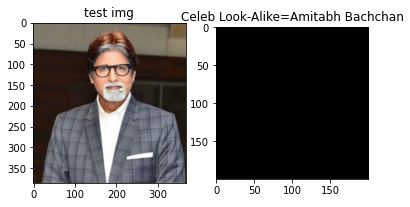

('test-images', 'sofia-solares.jpg')
celeb_mini/n00002238


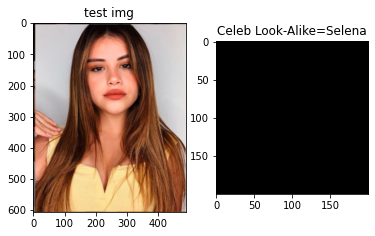

In [51]:
THRESHOLD = 0.6
# read image
testImages = glob.glob('test-images/*.jpg')

for test in testImages:
    print(os.path.split(test))
    im = cv2.imread(test)
    imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    #####################
    #  YOUR CODE HERE
    face = faceDetector(imDlib)
    celeb_img = np.zeros((200,200,3))
    celeb_name = 'unknown'
    if len(face)==1:
        shape = shapePredictor(imDlib, face[0])
        faceDescriptor = faceRecognizer.compute_face_descriptor(imDlib, shape)
        
        faceDescriptorList = [m for m in faceDescriptor]
        faceDescriptorNdarray = np.asarray(faceDescriptorList, dtype=np.float64)
        faceDescriptorNdarray = faceDescriptorNdarray[np.newaxis, :]
        
        distances = np.linalg.norm(faceDescriptorsEnrolled - faceDescriptorNdarray, axis=1)
        # Calculate minimum distance and index of this face
        argmin = np.argmin(distances)  # index
        minDistance = distances[argmin]  # minimum distance
        if minDistance <= THRESHOLD:
            celeb_name = labelMap[index[argmin]]
            celeb_dir = os.path.join(faceDatasetFolder, index[argmin])
            print(celeb_dir)
#             celeb_img_path = os.path.join(celeb_dir, os.listdir(celeb_dir)[0])
#             celeb_img = cv2.imread(celeb_img_path)
            
#             celeb_img = cv2.cvtColor(celeb_img, cv2.COLOR_BGR2RGB)
            

    ####################
    
    plt.subplot(121)
    plt.imshow(imDlib)
    plt.title("test img")
    
    #TODO - display celeb image which looks like the test image instead of the black image. 
    plt.subplot(122)
    plt.imshow(celeb_img)
    plt.title("Celeb Look-Alike={}".format(celeb_name))
    plt.show()